# CA684 Machine Learning Exercise 2 - Linear Regression

In this exercise we'll implement simple linear regression using gradient descent and apply it to an example problem.  We'll also extend our implementation to handle multiple variables and apply it to a slightly more difficult example.

# Linear regression with one variable

## In the first part of the exercise, we're tasked with implementing linear regression with one variable to predict house prices based on the per square foot area. Suppose you are a real estate agent are required to quote prices for houses based on their living room areas.

Let's start by importing some libraries and examining the data.

In [953]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage
import sklearn 
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
import pandas as pd 
from pandas import Series, DataFrame

In [954]:
import os
path = 'ex1data1.txt' # set path of the data
datai = pd.read_csv(path, header=None, names=['Area', 'Price']) # load data
datai.head() # display some rows

,Area,Price
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [955]:
datai.describe()  # compute some basic stats, e.g., mean, median, mode etc.

,Area,Price
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


Let's plot it to get a better idea of what the data looks like.

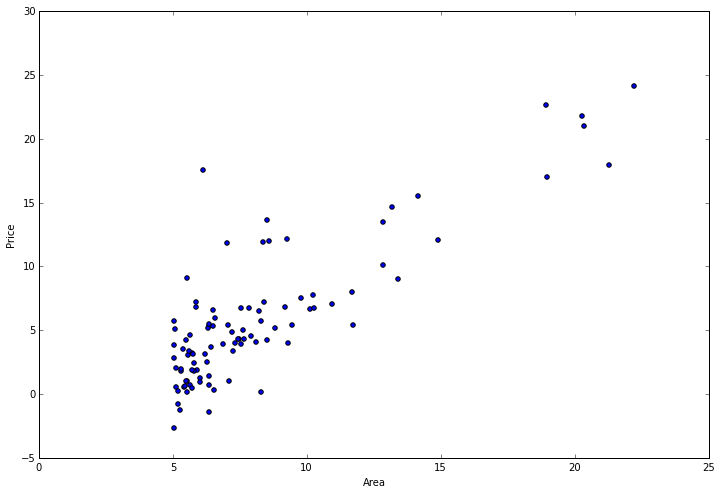

In [956]:
datai.plot(kind='scatter', x='Area', y='Price', figsize=(12,8))

<b> Linear Regression Overview: </b>

To establish notation for future use, we’ll use:
<ul>
<li>$x^i$ to denote the "input"
features of $n$ dimensions ($x^i \in \mathcal{R}^n$) ($n=1$ here because we have only the living area in this example), 
</li>
<li>
$y^i$ ($y^i \in \mathcal{R}$)
<li>"output" or target variable that we are trying to predict (in our example, price).
</li>
</ul>

A pair $(x^i, y^i)$ is called a training example, and the dataset
that we’ll be using to learn a list of m training examples $\{(x^i, y^i); i =1,\ldots ,m\}$ is called a training set.

Now let us try to describe a <b>model</b> that we'll try to fit this data, so that we can make
predictions for unknown values of $x$s (called the test set).

One way to represent the model is with the help of a function $h_\theta$ (a function parameterized by $\theta$).
$$ h_{\theta}(x) =  \theta_0 + \sum_{i=1}^{n} \theta_i x_i $$

Note that $\theta_0$ is a term which doesn't pair up with any x component and is called the <b>bias</b> or the <b>intercept</b> term. Assuming $x$ to be a $n+1$ dimensional vector with $x_0=1$, we can write the model in vector format.

$$ h_{\theta}(x) = \theta^T x, \theta, x \in \mathcal{R}^n$$

<b> Training the Model </b>

A reasonable approach would be to get this line (hyper-plane in $n$ dimensions) to be as close as possible to the given points. In other words we may look to minimize the squared differences between the predicted values (estimated by the model) and the true values (given).

$$J(\theta) = \frac{1}{2} \sum_{i=1}^{m} (h_\theta(x^i) - y^i)^2$$

The learning rule that we apply is called the <b>Gradient Descent</b> where we descend down the steepest slope at any given point:

$$ \theta_j = \theta_j - \alpha \frac{\partial }{\partial \theta_j} J(\theta)$$

With elementary calculus, considering only one training example $(x,y), $we compute:
$$\frac{\partial }{\partial \theta_j} J(\theta) = \sum_{j=1}^{m}(h_\theta(x)-y)x_j$$

Hence, for a single training example,
$$ \theta_j = \theta_j - \alpha (h_\theta(x)-y)x_j$$

This is called <b> Stochastic Gradient Descent</b>.

<pre>
    Loop N iterations {
        for i=1 to m, {
            for j=0 to n {
                theta[j] = theta[j] + alpha (y[i] − h(x[i]) * x[i][j]
            }
        }
    }
</pre>

<b> Python Implementation </b>

Now for some hands-on coding:

First we'll create a function to compute the cost of a given solution (characterized by the parameters theta).

In [957]:
def computeCost(X, y, theta):
    inner = np.power(((X * theta.T) - y), 2) # X, theta are vectors, .T is the transpose operator, y is a real
    return np.sum(inner) / (2 * len(X))

Let's add a column of ones to the training set so we can use a vectorized solution to computing the cost and gradients.

In [958]:
data = datai
data.insert(0, 'Ones', 1)


Now let's do some variable initialization.

In [959]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1] # extract out and merge columns 0...n-2 corresponds to xs and n-1 corresponds to y
y = data.iloc[:,cols-1:cols]

Let's take a look to make sure X (training set) and y (target variable) look correct.

In [960]:
X.head()

,Ones,Area
0,1,6.1101
1,1,5.5277
2,1,8.5186
3,1,7.0032
4,1,5.8598


In [961]:
y.head()

,Price
0,17.5920
1,9.1302
2,13.6620
3,11.8540
4,6.8233


The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  We also need to initialize theta.

In [962]:
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([0,0]))

Here's what theta looks like.

In [963]:
theta

matrix([[0, 0]])

Let's take a quick look at the shape of our matrices.

In [964]:
X.shape, theta.shape, y.shape

((97, 2), (1, 2), (97, 1))

Note that m=97, n=1 (n+1 = 2 due to the added dimension)

Now let's compute the cost for our initial solution (0 values for theta).

In [965]:
computeCost(X, y, theta)

32.072733877455676

So far so good.  Now we need to define a function to perform gradient descent on the parameters theta using the update rules defined in the text.

In [966]:
def gradientDescent(X, y, theta, alpha, iters):
    temp = np.matrix(np.zeros(theta.shape)) # 0 matrix for initialization
    parameters = int(theta.ravel().shape[1]) # convert to 1D vector from matrix
    cost = np.zeros(iters) # would be useful for plotting the cost value per iteration
    
    for i in range(iters):
        error = (X * theta.T) - y # 97x2 2x1 = 97x1 (matches with y dimension)
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j]) # element wise multiplication
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))
            theta = temp
            cost[i] = computeCost(X, y, theta)
        
    return theta, cost

Initialize some additional variables - the learning rate alpha, and the number of iterations to perform.

In [967]:
alpha = 0.01  # the learning rate
iters = 1000  # number of iterations

Now let's run the gradient descent algorithm to fit our parameters theta to the training set.

In [968]:
g, cost = gradientDescent(X, y, theta, alpha, iters)
g

matrix([[-3.24140214,  1.1272942 ]])

Finally we can compute the cost (error) of the trained model using our fitted parameters.

In [969]:
computeCost(X, y, g)

4.5159555030789118

Now let's plot the linear model along with the data to visually see how well it fits.

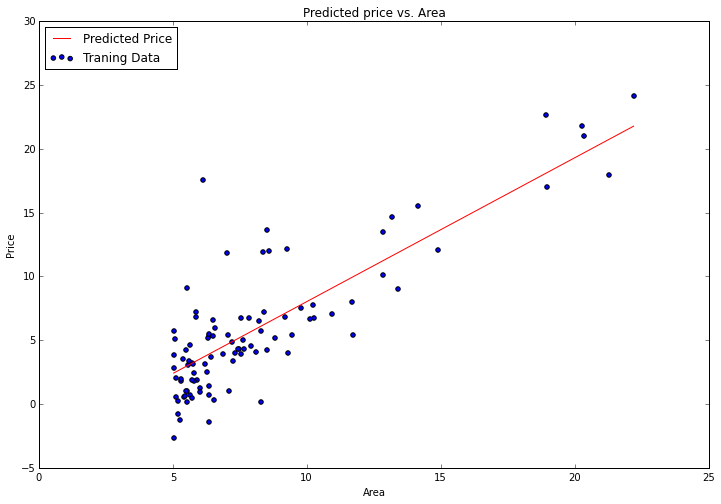

In [970]:
x = np.linspace(data.Area.min(), data.Area.max(), 100)
interceptu = g[0, 0] 
slopeu = g[0, 1]
f = interceptu + (slopeu * x)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, f, 'r', label='Predicted Price')
ax.scatter(data.Area, data.Price, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Area')
ax.set_ylabel('Price')
ax.set_title('Predicted price vs. Area')

Looks pretty good!  Since the gradient decent function also outputs a vector with the cost at each training iteration, we can plot that as well.  Notice that the cost always decreases - this is an example of a convex optimization problem.

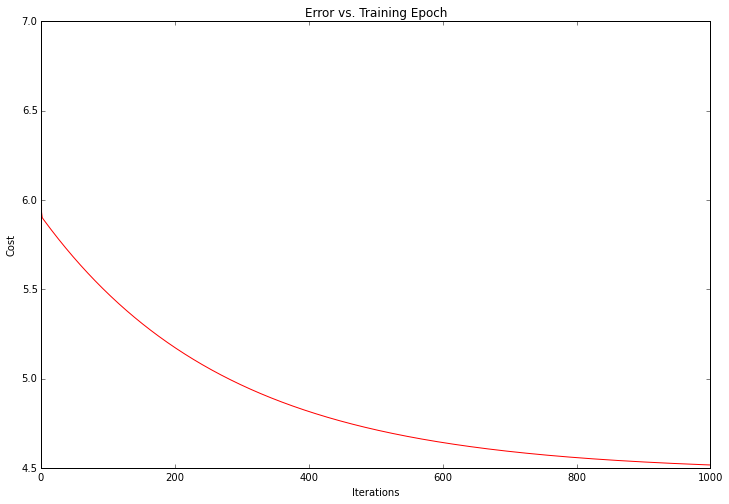

In [971]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

# Assignment: Linear regression with multiple variables

You're given a new data file which has "the number of bedrooms" as an additional factor determining the price of a house.
Your job is to rerun the Linear regression code and predict the house prices with this additional factor.
The name of the file is ex1data2.txt

For this task we add another pre-processing step - normalizing the features.  This is very easy with pandas.

Rerun the linear regression code on this new dataset and report the cost value. Plot the iterations vs. cost graph as well.

We can take a quick look at the training progess for this one as well.

Instead of implementing these algorithms from scratch, you could also use scikit-learn's linear regression function. 
The next part of the execrcise asks you to repeat the linear regression process on the two datasets, this time using python's built-in function instead of using your own version. Compare the solutions.

# Multivariate regression

In that first step of the exercise, we imported the second data set comprising the extra column of the number of rooms. Then, we showed some summary statistics of the dataset, noticing that this time, it contains 47 observations. 

In [972]:
#importing the second dataset 
houses = pd.read_csv("ex1data2.txt",header=None, names=['Area','Number Of Rooms', 'Price'])
housesdf = DataFrame(houses)
housesdf.head()

,Area,Number Of Rooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [973]:
housesdf.describe()

,Area,Number Of Rooms,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


## Normalization

Here we normalized the data in order to fit it to a [-1, 1] interval. In order to do this, we used the min_max_scaler method from sklearn.preprocessing. 

In [974]:
x = housesdf.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
housesdf_norm = pd.DataFrame(x_scaled,columns=["Area"," Number Of Rooms","Price"])
housesdf_norm1 = housesdf_norm
housesdf_norm.head()

/home/kevin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Area,Number Of Rooms,Price
0,0.345284,0.50,0.433962
1,0.206288,0.50,0.301887
2,0.426917,0.50,0.375660
3,0.155543,0.25,0.117170
4,0.592388,0.75,0.698113


In [975]:
housesdf_norm.insert(0, 'Ones', 1)

Here we computed the cost for our initial solution (0 values for theta) by using the already implemented functions. 

## Running the multivariate regression

We set the explanatory and response variables and used the preceding computeCost function to get the actual cost value of the model with initial theta parameters of value 0. 

In [976]:
#set explanatory and response variables
X1 = housesdf_norm.drop("Price",1)
y1 = housesdf_norm.Price
X1m = np.matrix(X1.values)
y1m = np.matrix(y1.values)
theta1 = np.matrix(np.array([0,0,0]))#one more parameter
computeCost(X1m, y1m, theta1)

3.7125553061712355

We ran again the gradient descent algorithm to fit our parameters theta to the training set.

In [977]:
alpha1 = 0.001
iters1 = 1000

We verified the dimensions of our variables in order not to return absurd results from a matrix multiplication. 

In [978]:
theta1.shape, X1m.shape, y1m.shape

((1, 3), (47, 3), (1, 47))

In [979]:
g1, cost1 = gradientDescent(X1m, y1m, theta1, alpha1, iters1)
g1

matrix([[ 0.30420596, -0.00884023,  0.03646272]])

And we computed the cost (error) of the trained model using our fitted parameters.

In [980]:
print 'The cost after applying gradient descent algorithm is :\n'  
computeCost(X1m, y1m, g1)

The cost after applying gradient descent algorithm is :



1.2810403489610249

We also plotted the graph of the cost function against the number of iterations of the gradient descent algorithm and noticed that this time too, the cost decreased and was characteristic of a convex optimization problem.

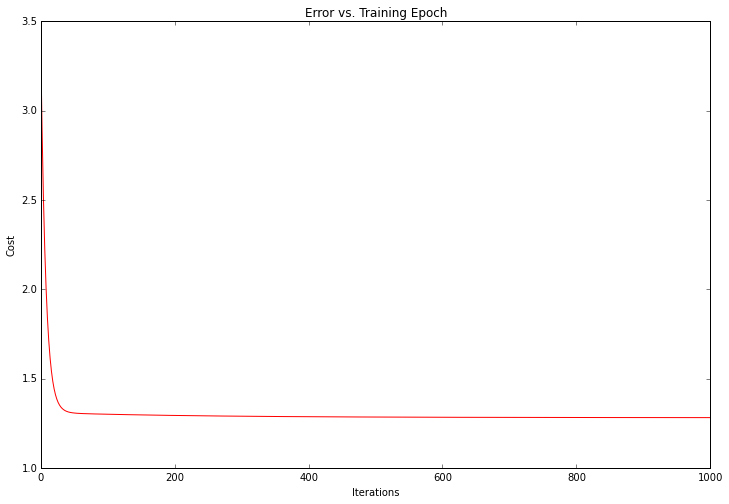

In [981]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost1, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

In the following, we tried to fit a model with the data using sklearn library and assessed whether the model was a good fit to our data, i.e. if the linear model could be used to describe the data and later allow us to make predictions. 

# Univariate regression with scikit-learn

Using sklearn to fit a model to our data was really handy and comprised 2 to 3 steps: 
<ol>
    <li>Creation of a Linear Regression object with LinearRegression()</li>
    <li>Use of the fit() function to fit the model</li>
    <li>Retrieve the estimated intercept and slope with intercept_ and the array coef_</li>
</ol>

In [982]:
#create a linear regression object
linalgu = LinearRegression()

In [983]:
#fit a linear regression model to the data and displaying estimated coefficients 
Xu = datai.drop("Price",1)
yu = datai.Price

#getting and storing estimator values
linalgu.fit(Xu, yu)
interceptsku = linalgu.intercept_ 
slopesku = linalgu.coef_[1]

print 'Estimated intercept coefficient = %f\nEstimated Slope= %f' % (interceptsku , slopesku )

Estimated intercept coefficient = -3.895781
Estimated Slope= 1.193034


The following function score returns the coefficient of correlation $R²$ = 0.70 which indicates that our linear regression model is a good fit to the data. 

In [984]:
linalgu.score(Xu, yu)

0.70203155378413973

In order to compare the parameter values obtained from scikit-learn to the ones obtained from scratch, we computed the relative differences: 

In [985]:
delta1 = math.fabs(interceptu  - interceptsku )/math.fabs(interceptsku )
delta2 = math.fabs(slopeu - slopesku)/math.fabs(slopesku)

In [986]:
print 'The relative difference between intercepts is %f %% \n' % (delta1 * 100)
print 'The relative difference between slopes is %f %%' % (delta2 * 100)

The relative difference between intercepts is 16.797113 % 

The relative difference between slopes is 5.510276 %


Hence, sklearn offered a convenient way for obtaining estimators thanks to the one single step of using the fit() function. 

# Multivariate regression with scikit learn 

Here we carried out the same steps as for the univariate regression with sklearn:

In [987]:
#create a linear regression object 
linalg = LinearRegression()


With sklearn, it only takes one step to do our linear regression. 

In [988]:
# getting and swaving estimators
linalg.fit(X1, y1)
interceptskm = linalg.intercept_  
coeffskm1 = linalg.coef_[1]
coeffskm2 = linalg.coef_[2]

print 'Estimated intercept coefficient = %f\nArea Feature = %f \nNumber of rooms feature = %f' % (interceptskm, coeffskm1,coeffskm2)

Estimated intercept coefficient = 0.055788
Area Feature = 0.952411 
Number of rooms feature = -0.065947


Let's compare features obtained from sklearn and the ones obtained from "scratch". 

With $R²$ = 0.73, we can assert that our multivariate regression model is a good fit to the data. 

In [989]:
linalg.score(X1, y1)

0.73294501802891432

In [990]:
interceptm = 0.30420596  
coeffm1 = -0.00884023
coeffm2 = 0.03646272

delta3 = math.fabs(interceptm  - interceptskm )/math.fabs(interceptm )
delta4 = math.fabs(coeffm1 + coeffskm1)/math.fabs(coeffskm1)
delta5 = math.fabs(coeffm2 + coeffskm2)/math.fabs(coeffskm2)

print 'The relative difference between intercepts is %f %% ' % (delta3 * 100)
print 'The relative difference between feature Area is %f %%' % (delta4 * 100)
print 'The relative difference between feature Number of rooms is %f %%' % (delta5 * 100)

The relative difference between intercepts is 81.661267 % 
The relative difference between feature Area is 99.071805 %
The relative difference between feature Number of rooms is 44.709318 %


There's more difference between the parameters obtained from scratch and  the one with sklearn than in the univariate regression. Sklearn returns coefficients used to build up the following linear regression equation: 
$$ Price = 0.055788 + 0.952411 * Area - 0.065947 * NumberOfRooms $$

## Relative significance of the descriptive features (Area, Number Of Rooms) on the Price

In the following lines, we assessed the importance of each estimators. The weights of the estimators indicate the effects of each one on the predictions made. Both sign and magnitude of the weights give us information about how the descriptive features affect the predictions. For example, the negative coefficient of the number of rooms, though small in magnitude, indicate with its negative sign that the price decreases slightly when this coefficient of the number of rooms increases. In the other hand, it seems that with a positive sign and a high magnitude the price of the house increases with respect to the area feature. 

However, it is tempting to infer the relative importance of the descriptive features based on the magnitudes of their weights. In fact, a more efficient way to draw some conclusions about the relative importance of the features in our model is to carry out a statistical significance test. 

We used a t-test for our linear regression model. 

<b>We tested the following null hypothesis:  feature did not have a significant impact on the model</b>. Thus, we computed the t-statistics and their associated p-values. 

In [991]:
#computing p-value and t-statistic 
#computing standard error for overall model 
seo = np.sqrt(np.sum((linalg.predict(X1) - y1) ** 2, axis=0) / (X1.shape[0] - X1.shape[1]-1))

# standard error for descriptive features
sef = [seo / np.sqrt(np.sum((X1 - np.mean(X1,axis=0))**2,axis=0))]

#compute t statistic 
t_stat = linalg.coef_ / sef

#compute p-value
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), y1.shape[0] - X1.shape[1]-1))

In [992]:
coefdf = DataFrame(housesdf_norm.columns)
coefdf.columns = ["Features"]
coefdf["Coefficient Estimate"] = Series(linalg.coef_)
coefdf["Standard Error"] = Series(np.squeeze(np.asfarray(sef).T,axis=1))
coefdf["t-statistic"] = Series(np.squeeze(np.asfarray(t_stat).T,axis=1))
coefdf["p-value"] = Series(np.squeeze(np.asfarray(p_value).T,axis=1))
coefdf.ix[1:3,:]

,Features,Coefficient Estimate,Standard Error,t-statistic,p-value
1,Area,0.952411,0.084832,11.226963,2.287059e-14
2,Number Of Rooms,-0.065947,0.097729,-0.674796,5.034176e-01
3,Price,NaN,NaN,NaN,NaN


By looking in the statistical table for the t-test, we deduced that if the p-value is less than 0.05, which corresponds to a 95% confidence interval; we had to reject the null hypothesis and as a consequence, the descriptive feature has a significant impact on the target values of our model.

Hence, by analysing the previous table we strongly infered that Area has a significant impact on the Price and the feature "Number Of Rooms" does not have a significant impact on the target value in our model. 

## Visualisation of our model in 3D

In [993]:
# extracting every column to make the 3D plot easier to plot 
area = X1["Area"]
nor = X1.ix[:,2]

Here we plotted the data points in a 3D graph and the plane which equation is the previous model one's to visualise how well it fits the data points. 

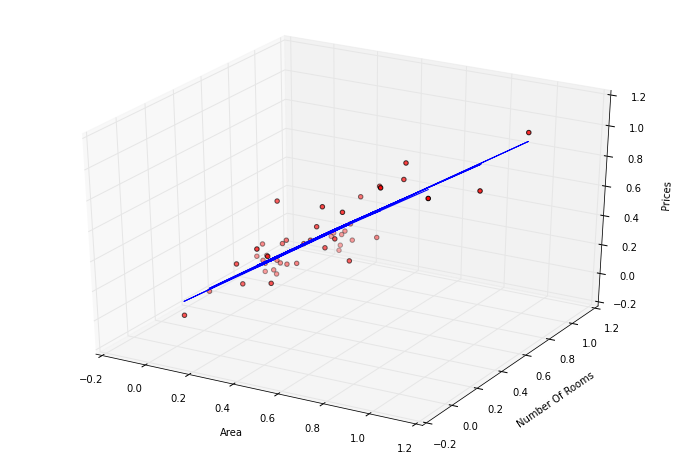

In [994]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(111, projection="3d")
ax1.scatter(np.array(area),np.array(nor),np.array(y1),c='r',marker='o')
f1 = interceptskm +  coeffskm1 * area + coeffskm2 * nor
ax1.plot(area, nor, f1, 'b', label='Predicted Price')
#set initial rotation angle of the 3D plot
ax1.view_init(azim=-60)
ax1.set_xlabel("Area")
ax1.set_ylabel("Number Of Rooms")
ax1.set_zlabel("Prices")
plt.show()

## Predicting prices with training and validation datasets

In this last part, we wanted to verify with another method that the training process was realized correctly using the multivariate regression model, i.e. the appropriateness of using a linear model to fit our training points. We used the cross_validation.train_test_split method to get a training set for prediction and a testing set for validation for both feature and target values. 

In [995]:
X_features = housesdf_norm.drop("Price", 1)
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X_features,y1)

In [996]:
lineag3 = LinearRegression()
lineag3.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [997]:
#prediction method
pred_train = lineag3.predict(X_train)
pred_test = lineag3.predict(X_test)

In [998]:
# we want MSE
print 'We want to fit a model X_train of the training set and compute the MSE with Y_train: %f' % np.mean((Y_train-pred_train)**2)
print 'We want to fit a model X_test of the training set and compute the MSE with Y_test: %f' % np.mean((Y_test-pred_test)**2)

We want to fit a model X_train of the training set and compute the MSE with Y_train: 0.013351
We want to fit a model X_test of the training set and compute the MSE with Y_test: 0.018671


The last step consisted in plotting the Residual plot, which shows residual on vertical axis and independant variables (price) on horizontal, with residual being defined as: 

$$ Residual = ObservedValue - FittedValue $$

In actuality, if the points are randomly dispersed around the horizontal axis, then the linear regression model is appropriate for the data. And this is the case here, because the points are randomly scattered along 0.

More explanations for choosing this method are explained at the following link: 
<a href="http://blog.minitab.com/blog/adventures-in-statistics/why-you-need-to-check-your-residual-plots-for-regression-analysis">Why You Need to Check Your Residual Plots for Regression Analysis: Or, To Err is Human, To Err Randomly is Statistically Divine</a>

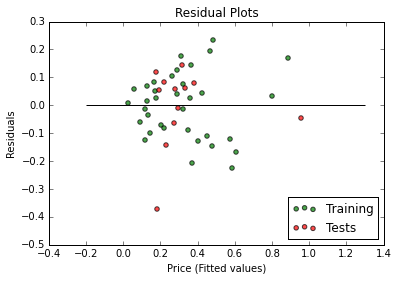

In [999]:
training_set = plt.scatter(pred_train,(pred_train - Y_train),c='g',alpha=0.7)
testing_set = plt.scatter(pred_test,(pred_test - Y_test),c='r',alpha=0.7)
plt.hlines(y=0,xmin=-0.2,xmax=1.3)
plt.legend((training_set,testing_set),('Training','Tests'),loc="lower right")
plt.title('Residual Plots')
plt.xlabel("Price (Fitted values)")
plt.ylabel("Residuals")


Values are randomly scattered around y=0 so linear regrssion was the right model to use. 